ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

Epoch 1/150, Loss: 0.6891, Accuracy: 0.5320
Epoch 2/150, Loss: 0.6378, Accuracy: 0.6447
Epoch 3/150, Loss: 0.5765, Accuracy: 0.7051
Epoch 4/150, Loss: 0.5396, Accuracy: 0.7429
Epoch 5/150, Loss: 0.5097, Accuracy: 0.7634
Epoch 6/150, Loss: 0.4886, Accuracy: 0.7730
Epoch 7/150, Loss: 0.4703, Accuracy: 0.7852
Epoch 8/150, Loss: 0.4374, Accuracy: 0.8102
Epoch 9/150, Loss: 0.4224, Accuracy: 0.8205
Epoch 10/150, Loss: 0.4043, Accuracy: 0.8265
Epoch 11/150, Loss: 0.3816, Accuracy: 0.8387
Epoch 12/150, Loss: 0.3650, Accuracy: 0.8543
Epoch 13/150, Loss: 0.3370, Accuracy: 0.8618
Epoch 14/150, Loss: 0.3035, Accuracy: 0.8781
Epoch 15/150, Loss: 0.2924, Accuracy: 0.8832
Epoch 16/150, Loss: 0.2805, Accuracy: 0.8953
Epoch 17/150, Loss: 0.2742, Accuracy: 0.8947
Epoch 18/150, Loss: 0.2453, Accuracy: 0.9075
Epoch 19/150, Loss: 0.2628, Accuracy: 0.9070
Epoch 20/150, Loss: 0.2238, Accuracy: 0.9160
Epoch 21/150, Loss: 0.2057, Accuracy: 0.9222
Epoch 22/150, Loss: 0.2122, Accuracy: 0.9153
Epoch 23/150, Loss:

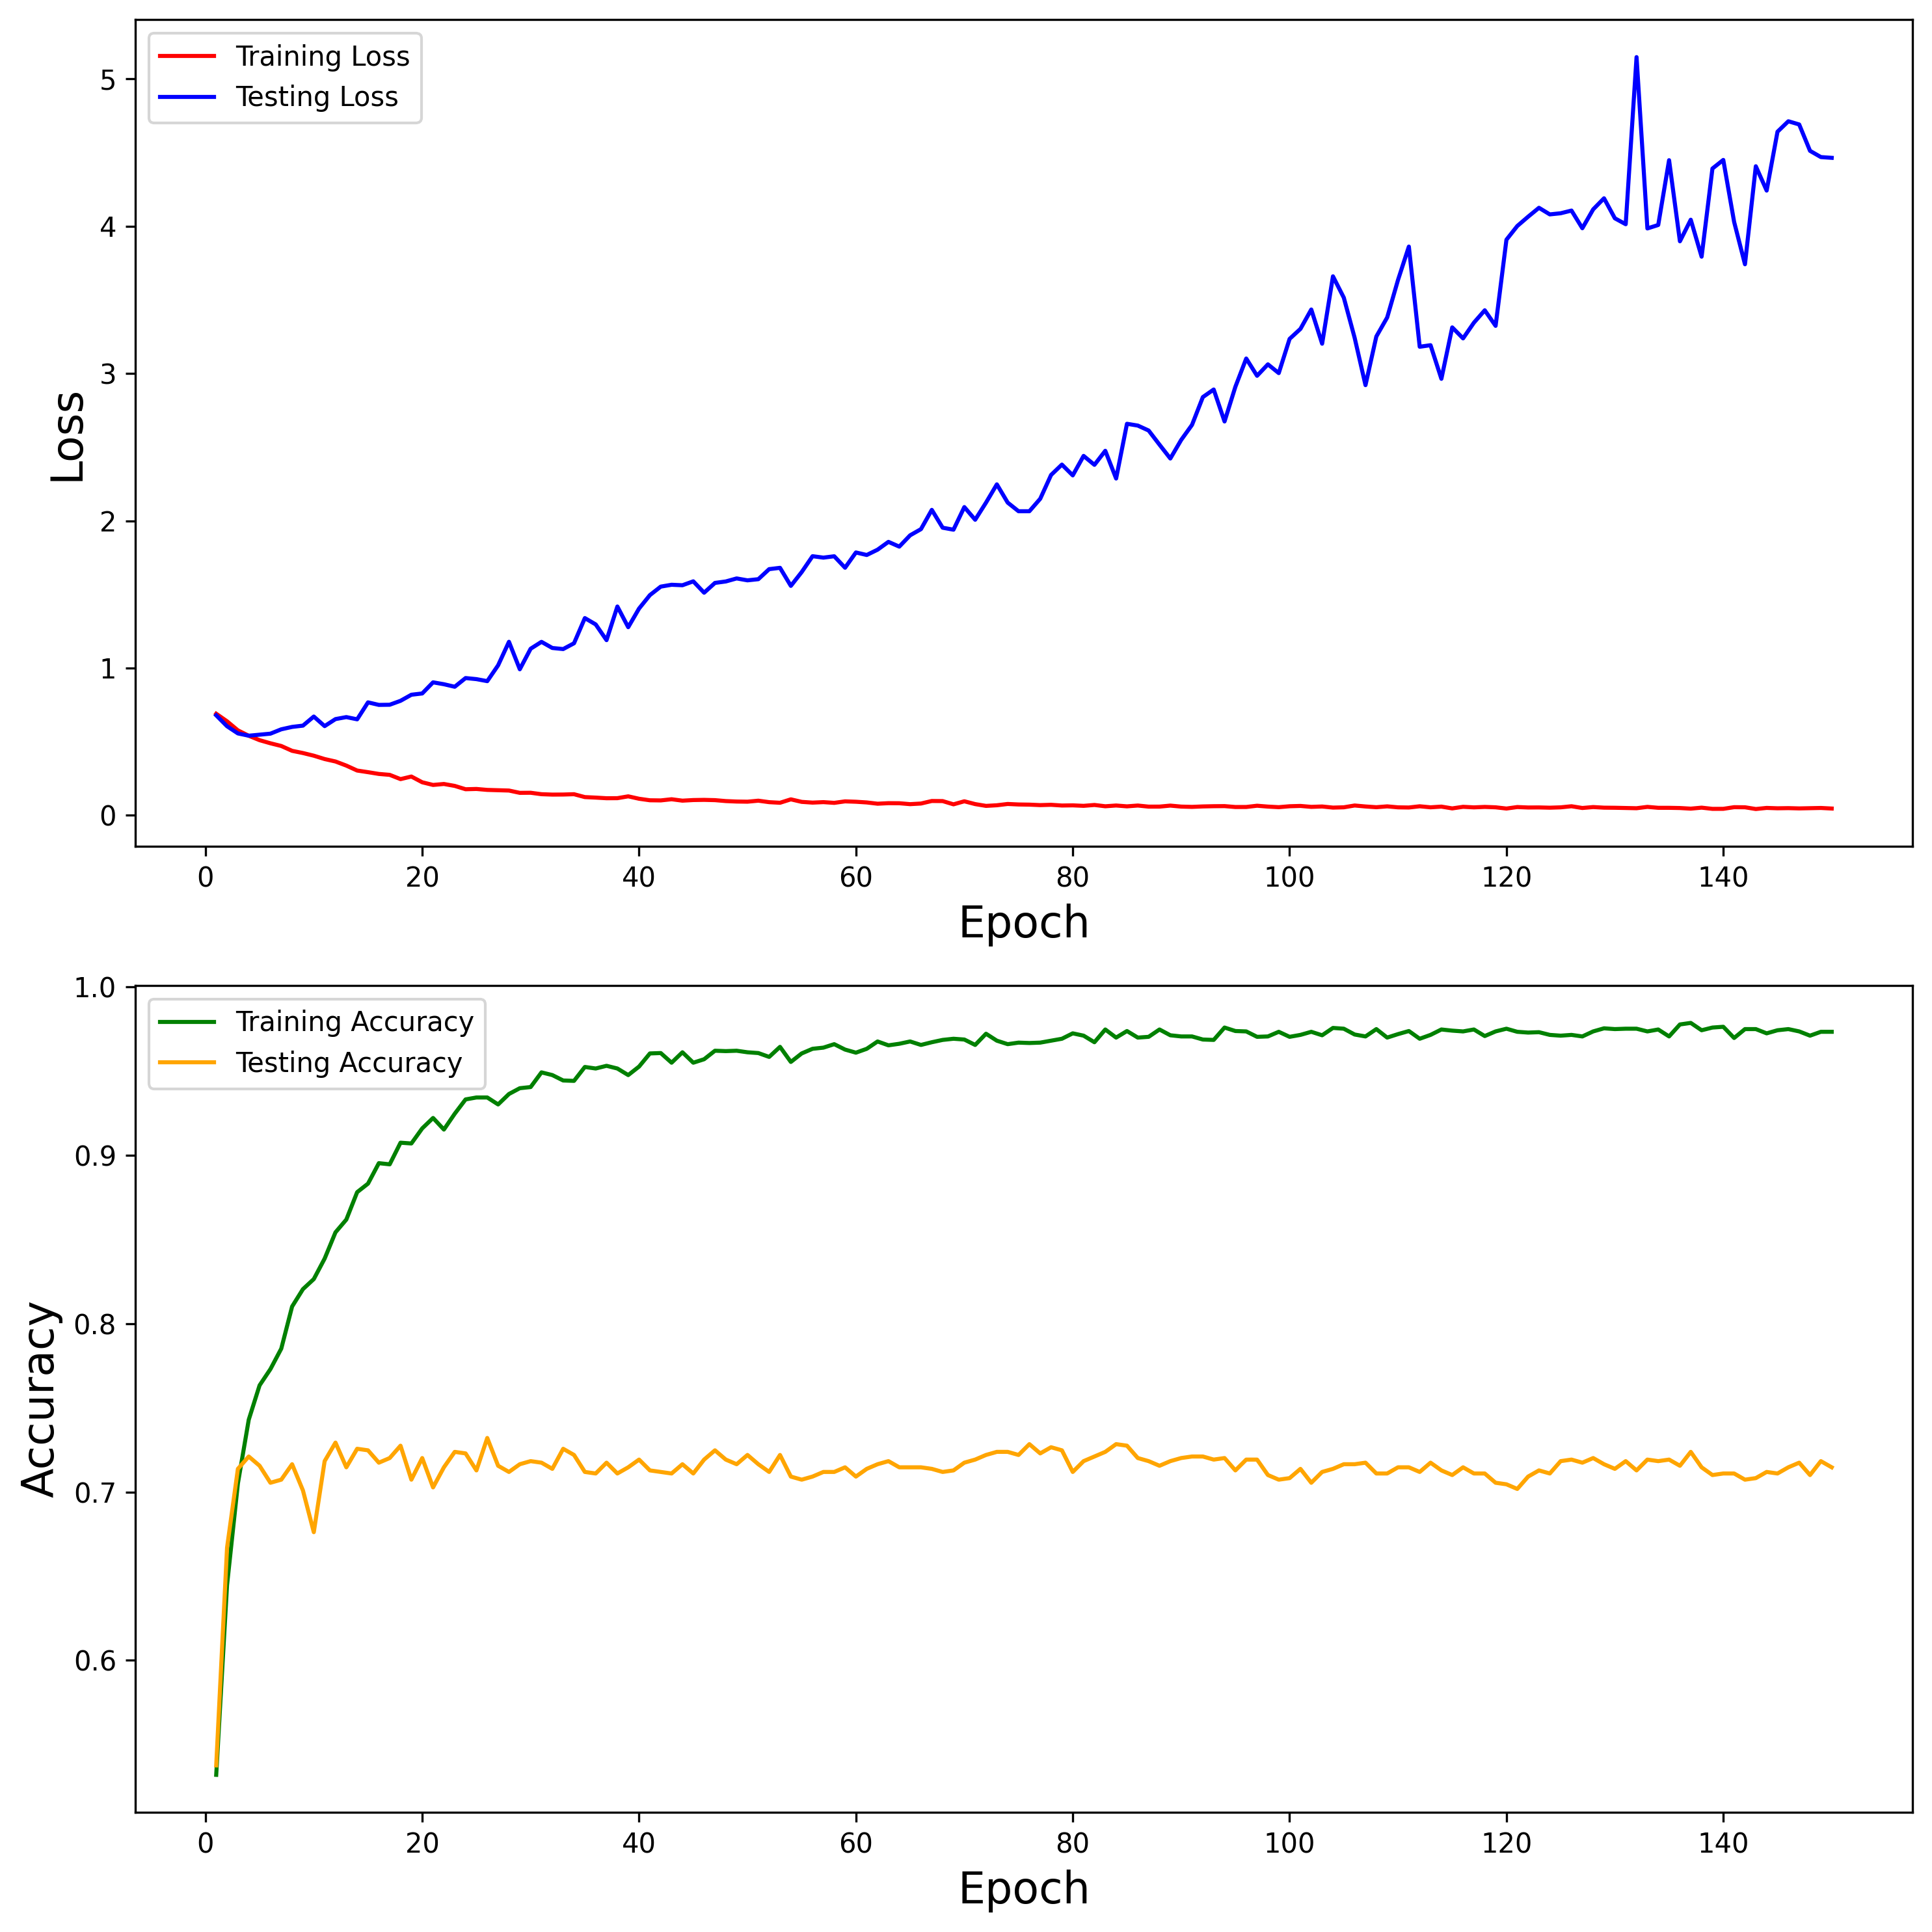

AUC: 0.7869095104218471
MAE: 0.286303014619927
Accuracy: 0.7146788990825688
Balanced Accuracy: 0.7118065775540376


In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score, mean_absolute_error, accuracy_score, confusion_matrix, balanced_accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import matplotlib.pyplot as plt

# Read train and test data
data_train = pd.read_excel("train_smiles.xlsx")
data_test = pd.read_excel("test_smiles.xlsx")

# Preprocess the SMILES strings
def preprocess_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.SanitizeMol(mol)
    return mol

# Preparation of training set
data_train['Molecule'] = data_train['smiles'].apply(preprocess_smiles)
data_train = data_train.dropna()
data_train['Fingerprint'] = data_train['Molecule'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))
X_train = torch.tensor(data_train['Fingerprint'].tolist(), dtype=torch.float32)
y_train = torch.tensor(data_train['Target'].values, dtype=torch.float32)

# Preparation of test set
data_test['Molecule'] = data_test['smiles'].apply(preprocess_smiles)
data_test = data_test.dropna()
data_test['Fingerprint'] = data_test['Molecule'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))
X_test = torch.tensor(data_test['Fingerprint'].tolist(), dtype=torch.float32)
y_test = torch.tensor(data_test['Target'].values, dtype=torch.float32)

# Define the GCNN model
class GCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout_rate):
        super(GCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# Hyperparameters assignment
input_dim = 1024
hidden_dim1 = 128
hidden_dim2 = 64
hidden_dim3 = 32
dropout_rate = 0.5

# Initialize the model
model = GCNN(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout_rate)
learning_rate = 0.07
batch_size=32
criterion = nn.BCELoss()

# choose any one optimzer out of the three at a time

#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, initial_accumulator_value=0.1)
#optimizer = optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.9, eps=1e-06)


# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize lists to store values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 150
# Training the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        predictions = (outputs > 0.5).squeeze().int()
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_samples    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Store values for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluation on the test set
    model.eval()
    test_running_loss = 0.0
    test_correct_predictions = 0
    test_total_samples = 0
    test_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            test_running_loss += loss.item() * inputs.size(0)
            predictions = (outputs > 0.5).squeeze().int()
            test_correct_predictions += (predictions == labels).sum().item()
            test_total_samples += labels.size(0)
            test_predictions.extend(outputs.squeeze().tolist())
    
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_accuracy = test_correct_predictions / test_total_samples
    
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_accuracy)

# Plotting loss and accuracy as subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=300)

# Plot training and test loss
ax1.plot(np.arange(1, num_epochs + 1), train_losses, color='red', label='Training Loss')
ax1.plot(np.arange(1, num_epochs + 1), test_losses, color='blue', label='Testing Loss')
ax1.set_xlabel('Epoch', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.legend()

# Plot training and test accuracy
ax2.plot(np.arange(1, num_epochs + 1), train_accuracies, color='green', label='Training Accuracy')
ax2.plot(np.arange(1, num_epochs + 1), test_accuracies, color='orange', label='Testing Accuracy')
ax2.set_xlabel('Epoch', fontsize=16)
ax2.set_ylabel('Accuracy', fontsize=16)
ax2.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("GCNN_Training_Test_Loss_Accuracy_adadelta.png")
plt.show()

model.eval()
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())


# Calculate evaluation metrics
auc = roc_auc_score(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
accuracy = accuracy_score(y_test, (torch.tensor(predictions) > 0.5).int())
balanced_accuracy = balanced_accuracy_score(y_test, (torch.tensor(predictions) > 0.5).int())

print("AUC:", auc)
print("MAE:", mae)
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)

In [2]:
torch.save(model.state_dict(), 'best_model.pth')

# external validation

In [3]:
# Read external data
external_data = pd.read_excel("external_smiles.xlsx")

# Preprocess the SMILES strings
external_data['Molecule'] = external_data['SMILES'].apply(preprocess_smiles)
external_data = external_data.dropna()
external_data['Fingerprint'] = external_data['Molecule'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))
X_external = torch.tensor(external_data['Fingerprint'].tolist(), dtype=torch.float32)


In [4]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Create DataLoader for external dataset
external_dataset = TensorDataset(X_external)
external_loader = DataLoader(external_dataset, batch_size=batch_size)

# Predict probabilities & labels
external_predictions = []
external_labels = []
with torch.no_grad():
    for inputs in external_loader:
        inputs = inputs[0]
        outputs = model(inputs)
        external_predictions.extend(outputs.squeeze().tolist())
        external_labels.extend((outputs > 0.5).squeeze().int().tolist())

external_data['Predicted_Probabilities'] = external_predictions
external_data['Predicted_Labels'] = external_labels
external_data.to_excel("external_predictions_adadelta.xlsx", index=False)